In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

import cortex

# OpenNeuro equivalent: xfms = json.load("derivative/subject_xfms.json")
# Comment the following 2 lines if using OpenNeuro.
import cottoncandy as cc
xfms = cc.get_interface("story-mri-data", verbose=False).download_json("subject_xfms")

In [2]:
subject_codes = ["UTS03", "UTS08"]
# Map OpenNeuro subjects to internal pycortex database.
# If using OpenNeuro, just set `subject = subject_code`.
subject_code_mapping = {"UTS03": "UTS03", "UTS08": "UTS08"}

(95556,)
(95556,)
(97023,)
(97023,)


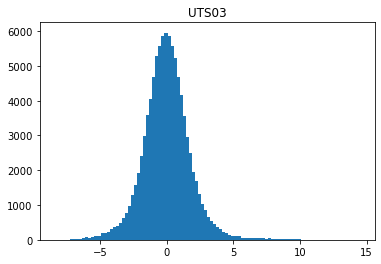

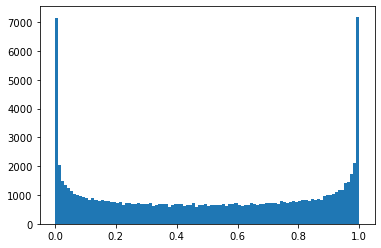

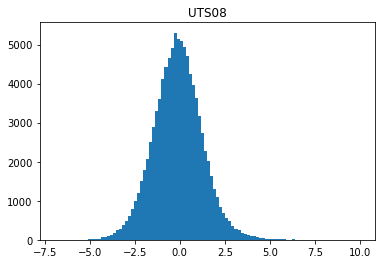

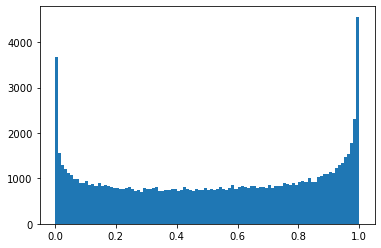

In [3]:
vot, vop = {}, {}
for subject_code in subject_codes:
    vot[subject_code] = np.load(f"results/{subject_code}_fedorenko_ttest_greater.npz")["vot"]
    print(vot[subject_code].shape)
    plt.figure()
    plt.hist(vot[subject_code], bins=100)
    plt.title(subject_code)
    vop[subject_code] = np.load(f"results/{subject_code}_fedorenko_ttest_greater.npz")["vop"]
    print(vop[subject_code].shape)
    plt.figure()
    plt.hist(vop[subject_code], bins=100)

In [4]:
def fdr_correct(pval, thres):
    """Find the fdr corrected p-value thresholds
    pval - vector of p-values
    thres - FDR level
    pID - p-value thres based on independence or positive dependence
    pN - Nonparametric p-val thres"""
    # remove NaNs
    p = pval[np.nonzero(np.isnan(pval)==False)[0]]
    p = np.sort(p)
    V = float(len(p))
    I = np.arange(V) + 1

    cVID = 1
    cVN = (1/I).sum()

    th1 = np.nonzero(p <= I/V*thres/cVID)[0]
    th2 = np.nonzero(p <= I/V*thres/cVN)[0]
    if len(th1)>0:
       pID = p[th1.max()]
    else:
       pID = -np.inf
    if len(th2)>0:
       pN =  p[th2.max()]
    else:
       pN = -np.inf

    return pID, pN

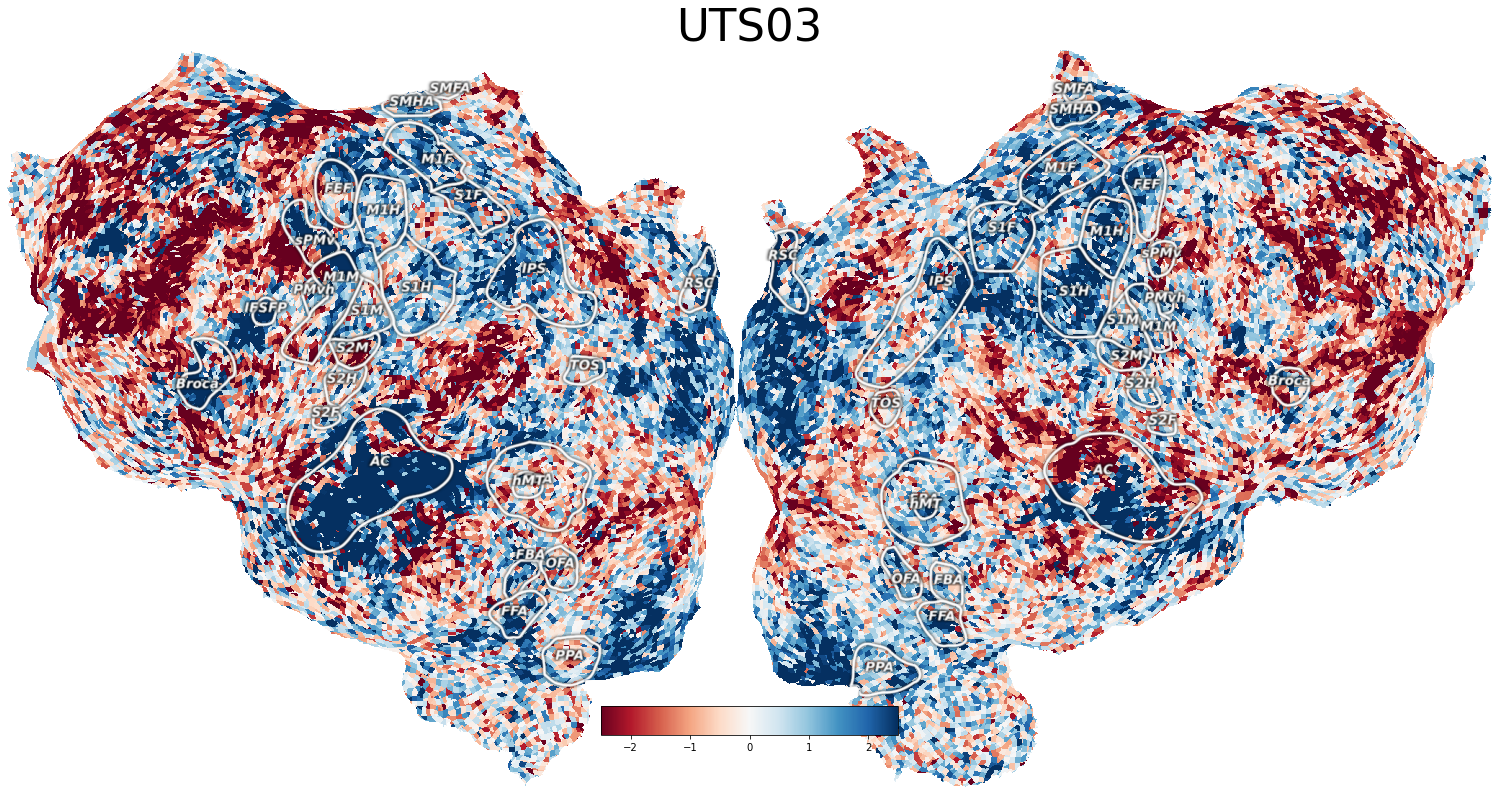

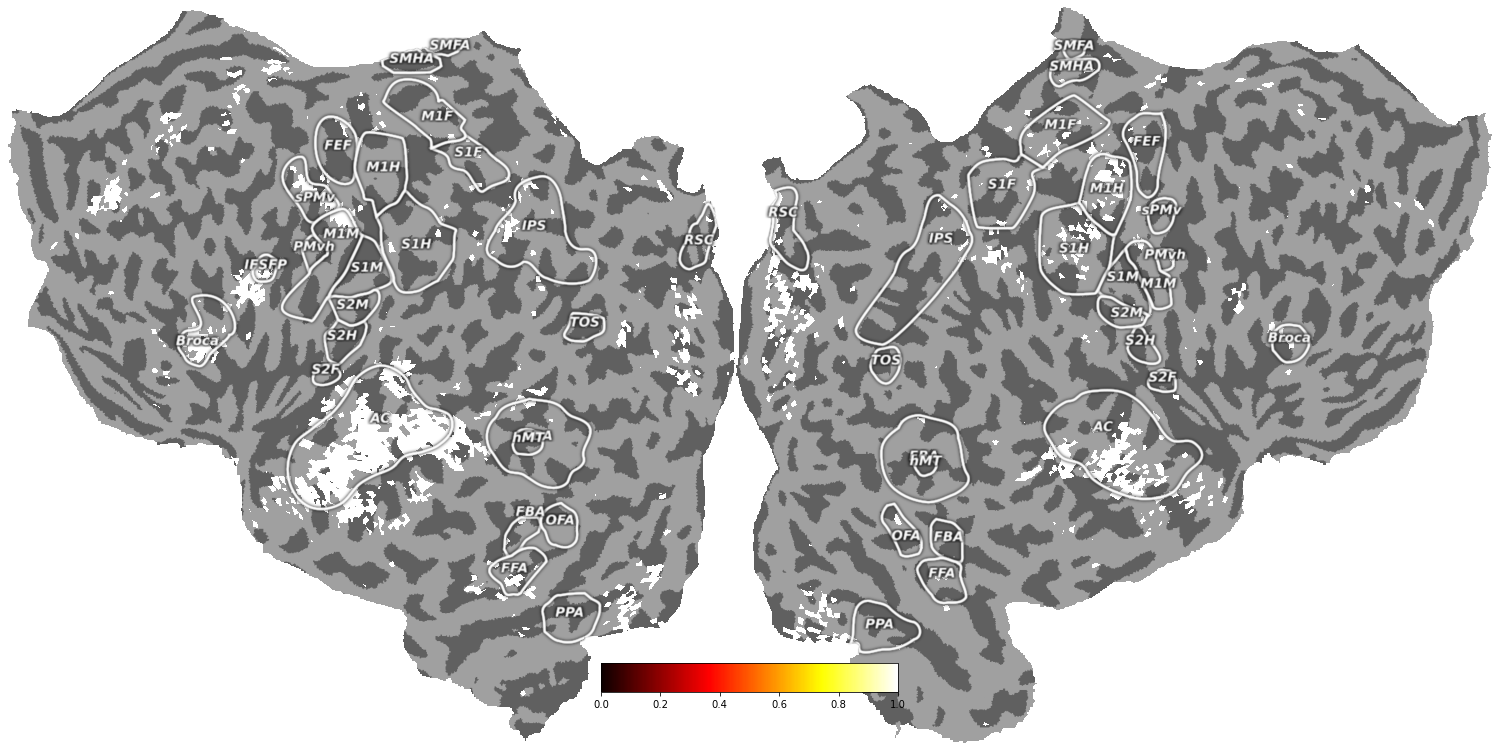

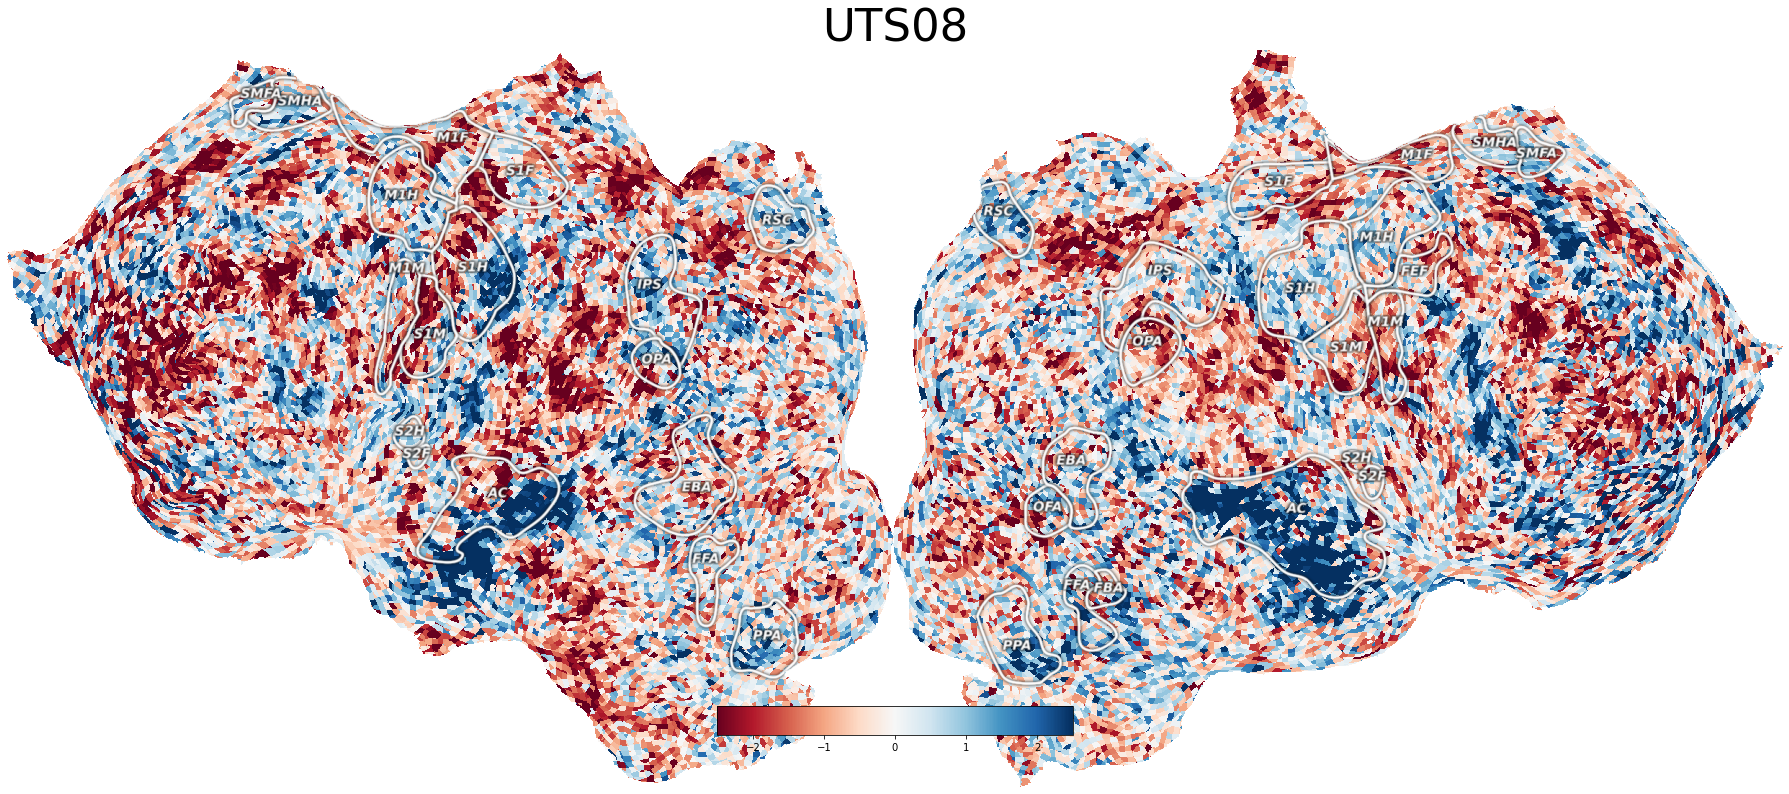

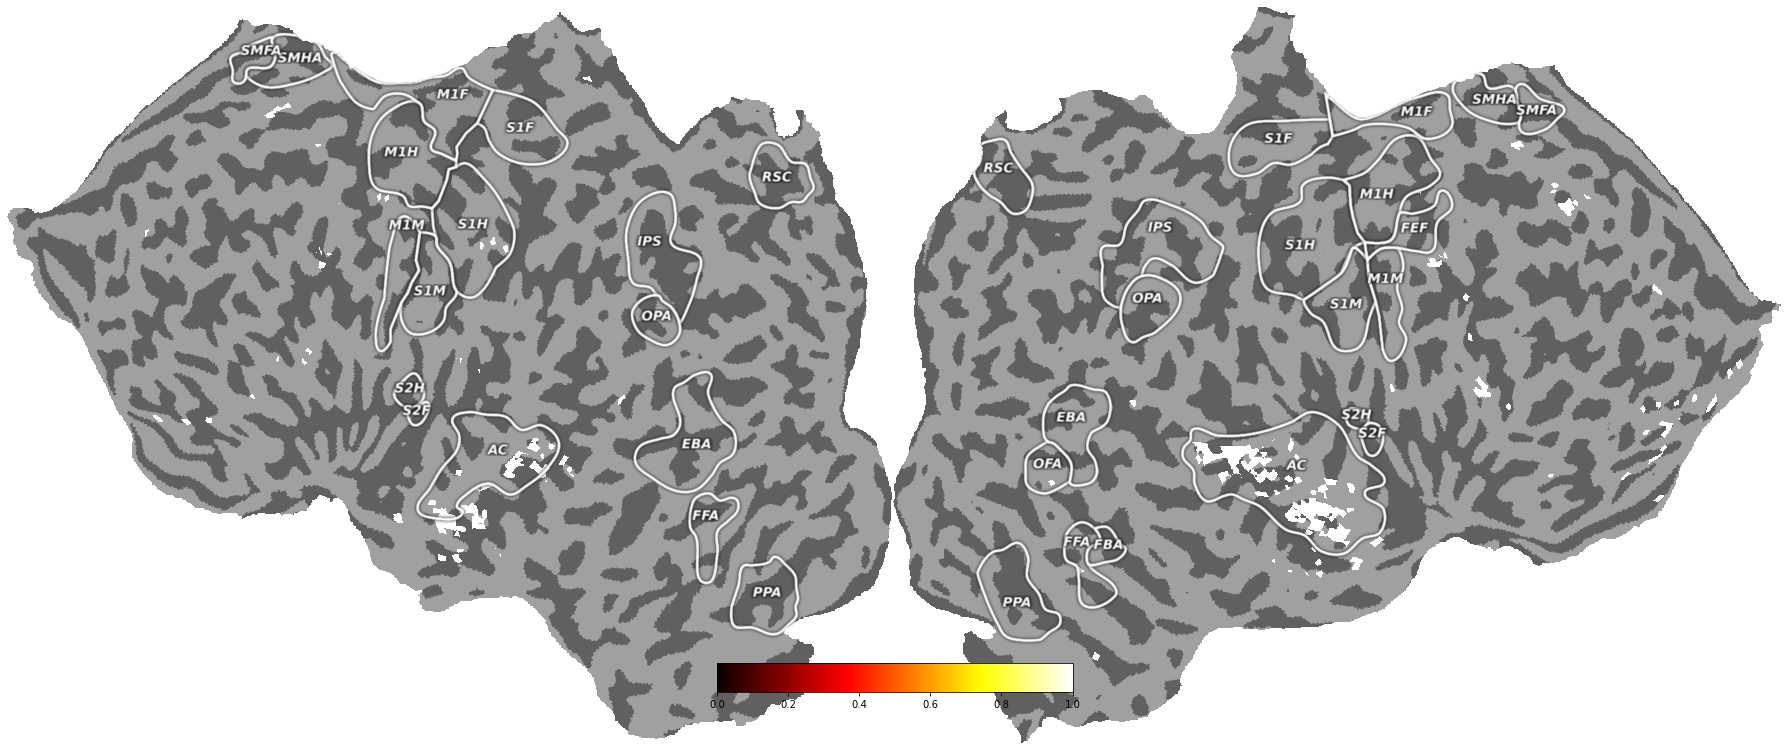

In [5]:
for subject_code in subject_codes:
    subject = subject_code_mapping[subject_code]
    
    # Blue (higher t-stastitic) implies that OG responses > degraded responses.
    t_statistic_vol = cortex.Volume(vot[subject_code], subject, xfms[subject], vmin=-2.5, vmax=2.5, cmap="RdBu")
    _ = cortex.quickshow(t_statistic_vol, with_labels=True, with_rois=True, with_curvature=True,
                         curvature_threshold=True, linewidth=4, thick=1,
                         with_colorbar=True)
    plt.title(subject_code, fontsize=45)
    cortex.quickflat.make_png(f"results/{subject_code}_fedorenko_tstats",
                              t_statistic_vol, dpi=300, with_labels=True, with_rois=True,
                              with_colorbar=True, with_curvature=True,
                              curvature_threshold=True, linewidth=4,thick=1, alpha=0.1)
    
    pvals = np.nan * np.ones_like(vop[subject_code])
    pID, pN = fdr_correct(vop[subject_code], 0.1)
    pvals[vop[subject_code]<=pN] = 1
    pval_vol = cortex.Volume(pvals, subject, xfms[subject], vmin=0, vmax=1, cmap="hot")
    _ = cortex.quickshow(pval_vol, with_labels=True, with_rois=True, with_curvature=True,
                         curvature_threshold=True, linewidth=4, thick=1,
                         with_colorbar=True)
    cortex.quickflat.make_png(f"results/{subject_code}_fedorenko_pvals",
                              pval_vol, dpi=300, with_labels=True, with_rois=True,
                              with_colorbar=True, with_curvature=True,
                              curvature_threshold=True, linewidth=4,thick=1, alpha=0.1)